In [1]:
!pip install scanpy==1.9.1
!pip install matplotlib==3.6
!pip install plotly
!pip install -U kaleido

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 54.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.0/103.0 kB 11.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.2/88.2 kB 9.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 61.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.5/63.5 kB 7.3 MB/s eta 0:00:00
  Created wheel for umap-learn: filename=umap_learn-0.5.3-py3-none-any.whl size=82816 sha256=c84d3319ec26c3c95d7cf665a501d8ff03903aa55f91d6677724fc0aa28e8e0e
  Stored in directory: /root/.cache/pip/wheels/a0/e8/c6/a37ea663620bd5200ea1ba0907ab3c217042c1d035ef606acc
  Created wheel for session-info: filename=session_info-1.0.0-py3-none-any.whl size=8026 sha256=b3b326ca736f086d05

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 20.0 MB/s eta 0:00:00


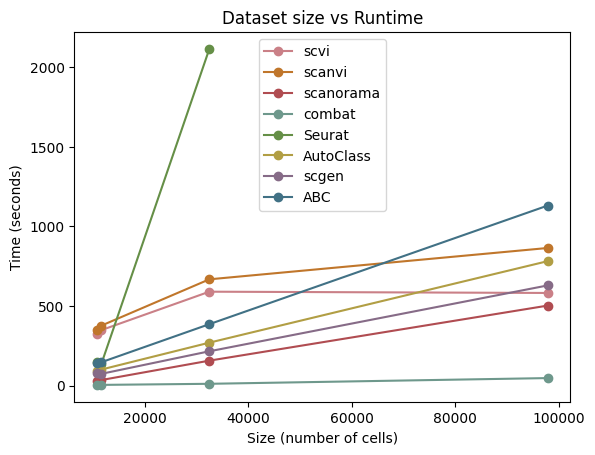

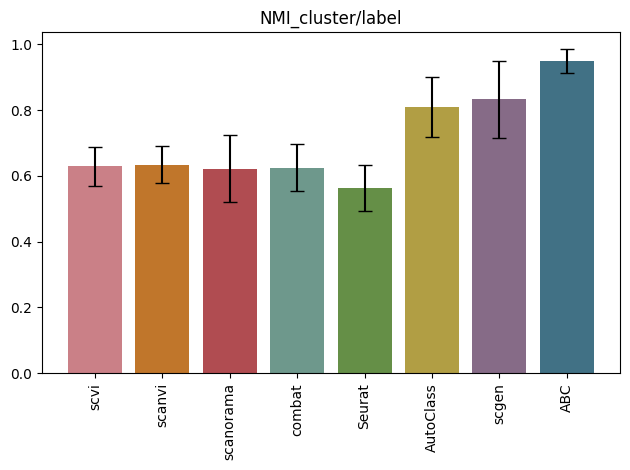

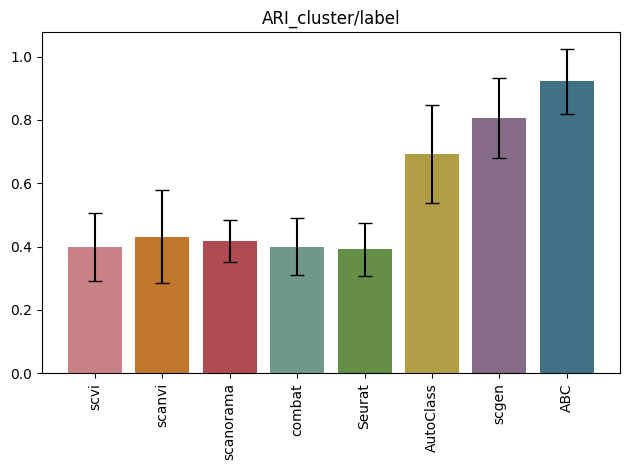

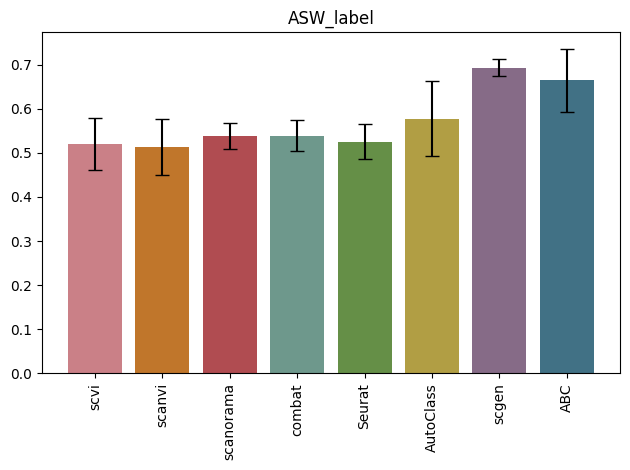

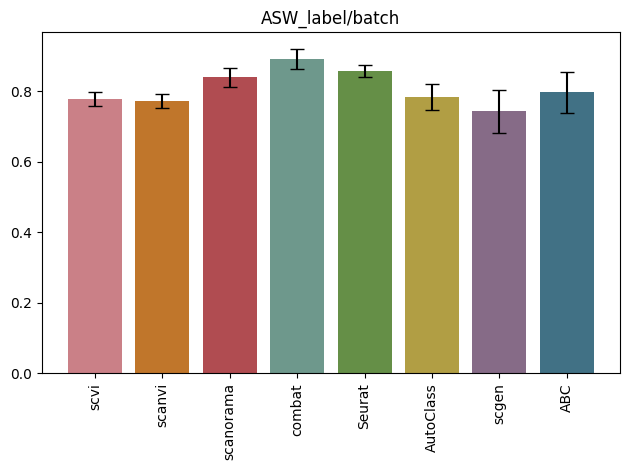

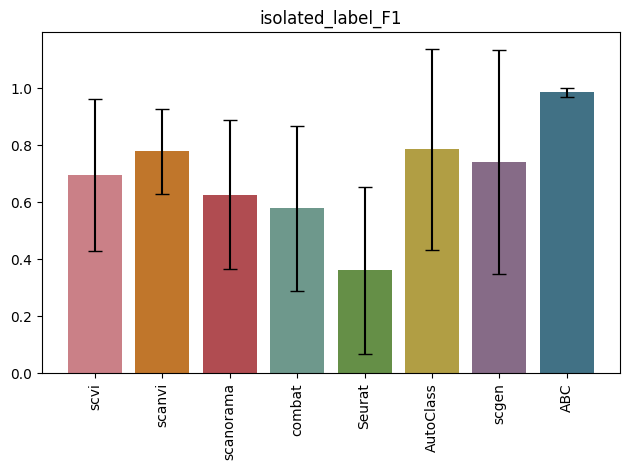

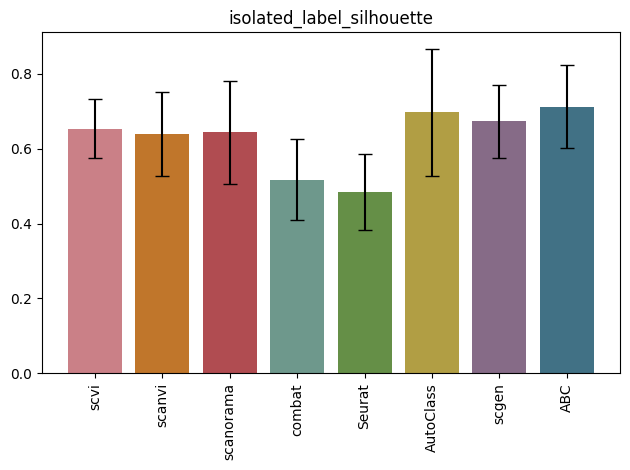

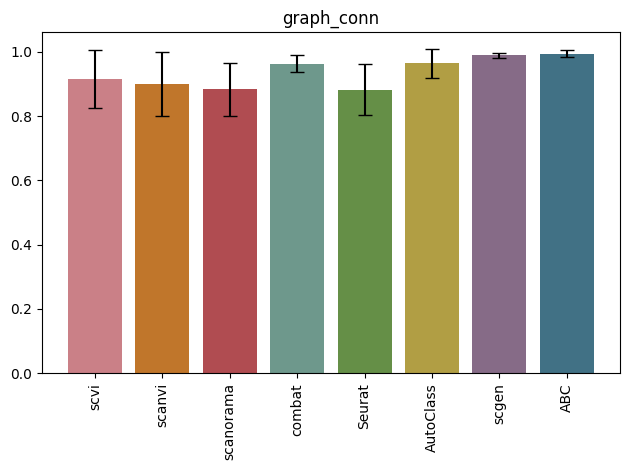

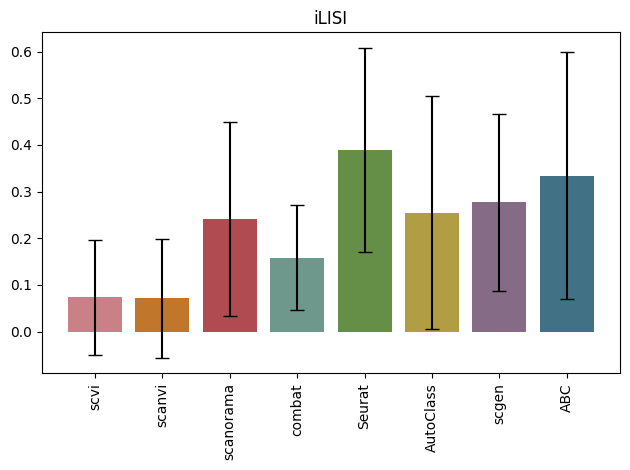

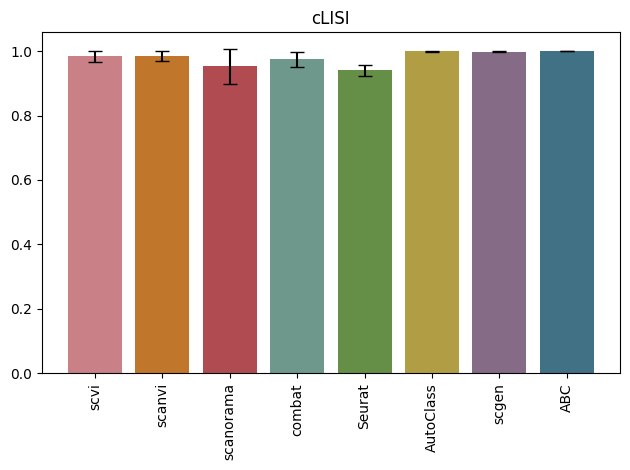

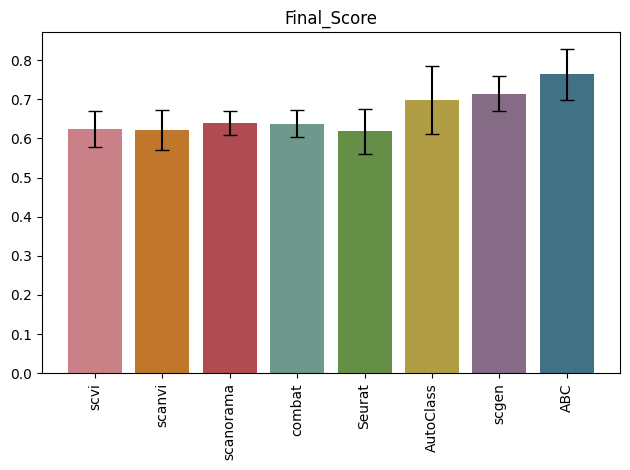

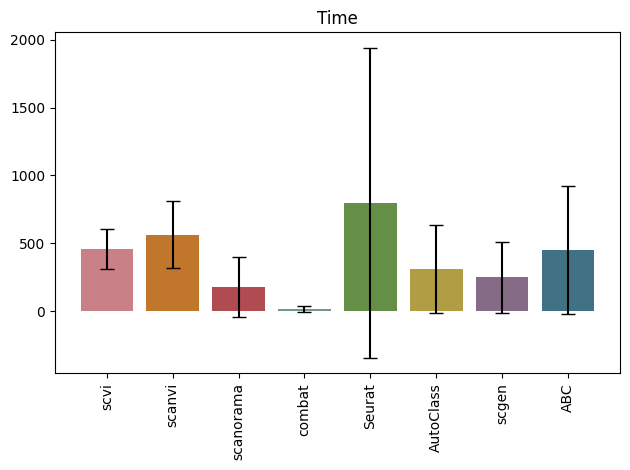

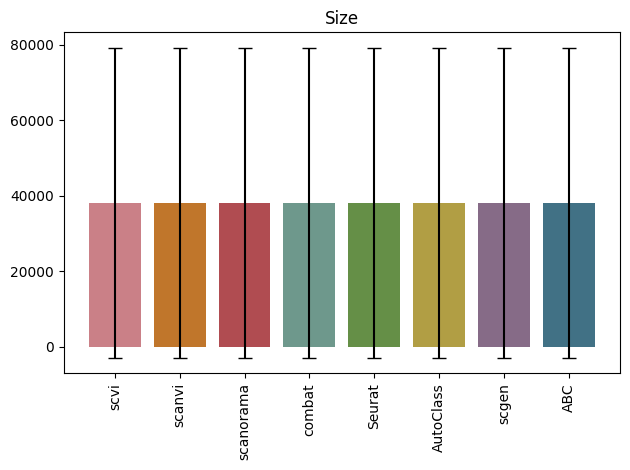

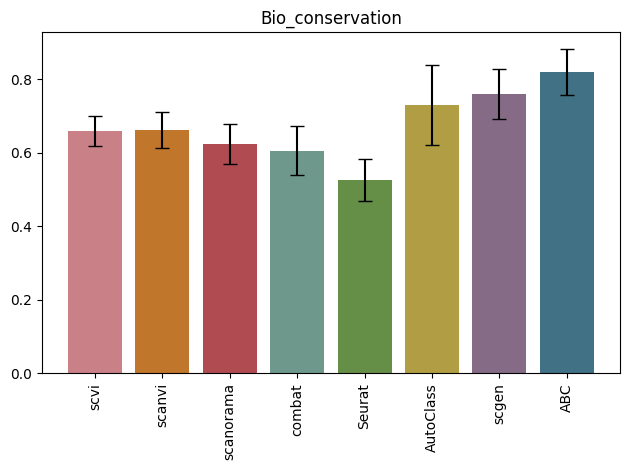

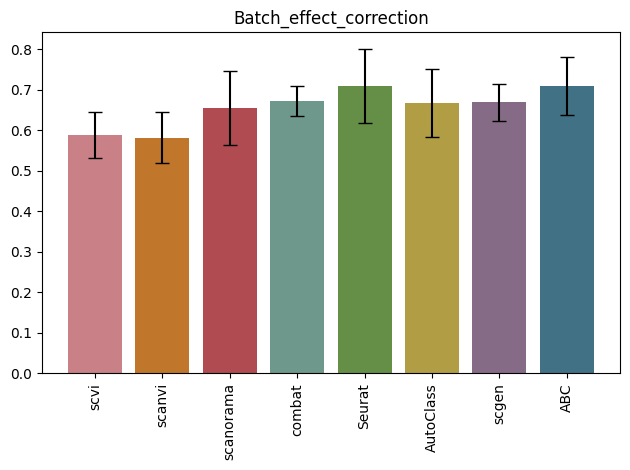

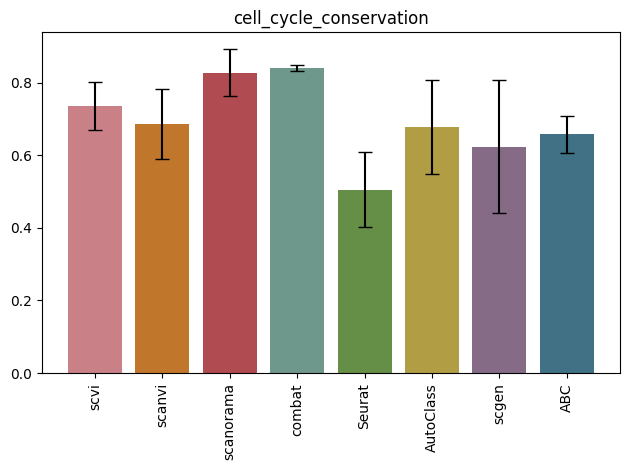

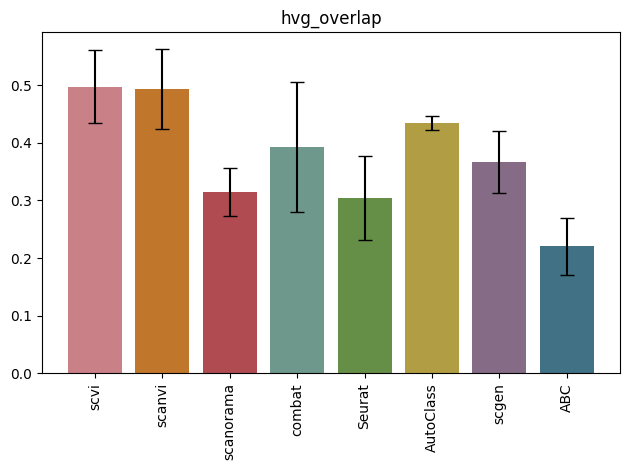

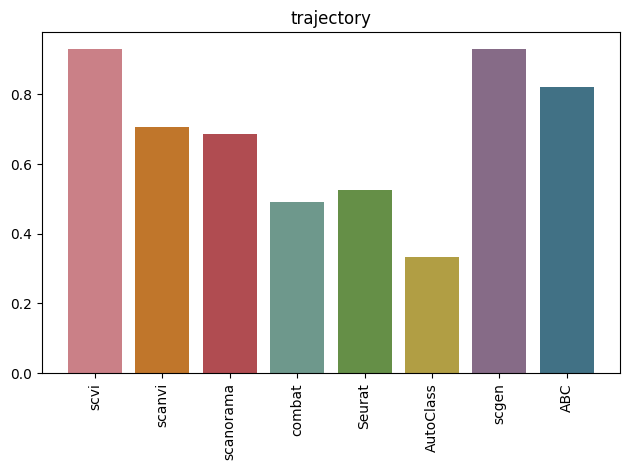

In [2]:
import os
from pathlib import Path
import numpy as np
import sys
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

sys.path.insert(0,'/content/drive/MyDrive/modules/')
import plottingData

SAVE_FIG = False

datasets = {
  'small_atac_windows':
      {
        'label_key': 'final_cell_label',
        'batch_key': 'batchname',
        'ATAC': True,
        'subsample': 1,
        'size' : 10761,
        'log': True},

  'small_atac_peaks':
      {
        'label_key': 'final_cell_label',
        'batch_key': 'batchname',
        'ATAC': True,
        'subsample': 1,
        'size' : 11597,
        'log': True},

  # --- Not including the datasets used for hyperparameter optimization ---
  # 'small_atac_gene_activity':
  #     {
  #       'label_key': 'final_cell_label',
  #       'batch_key': 'batchname',
  #       'ATAC': True,
  #       'subsample': 1,
  #       'size' : 11270,
  #       'log': True},
                  
  # 'human_pancreas_norm_complexBatch':
  #     {
  #       'label_key': 'celltype',
  #       'batch_key': 'tech',
  #       'ATAC': False,
  #       'subsample': 1,
  #       'size' : 16382,
  #       'log': False},
  
  'Lung_atlas_public':
      {
        'label_key': 'cell_type',
        'batch_key': 'batch',
        'subsample': 1,
        'size' : 32472,
        'ATAC': False,
        'log': False},


  'Immune_ALL_hum_mou':
      {
        'label_key': 'final_annotation',
        'batch_key': 'batch',
        'subsample': 1,
        'size' : 97861,
        'ATAC': False,
        'log': False},
}


# list of methods to compare
methods = [
            'scvi',
            'scanvi',
            'scanorama',
            'combat',            
            'Seurat',
            'AutoClass',
            'scgen',
            'ABC',
            ]


# Define the metric categories
bio_con_metrics = ['ARI_cluster/label', 'cLISI',                     
                    'isolated_label_silhouette', 'isolated_label_F1',
                    'NMI_cluster/label', 'ASW_label', 
                   'cell_cycle_conservation', 'hvg_overlap', 'trajectory']
batch_corr_metrics = ['graph_conn', 'iLISI', 'ASW_label/batch']

base_path = '/content/drive/MyDrive/Colab Notebooks/integrationDatasets/'
path = os.path.join(base_path, 'final_metrics')
save_path = os.path.join(base_path, 'metricsPlots')

# create directory if does not exists
Path(save_path).mkdir(parents=True, exist_ok=True)
dpi = 300

# set plotting colors
colors = ['#ca8087', '#c0762b', '#b04c51', '#6e988c', '#658f47', '#b19e44', '#866b87', '#417185']



# --- Load and process files ---

# Load the CSV files into pandas DataFrames
dfs = []
for dataset_name in datasets.keys():
  metrics_file = os.path.join(path, f'{dataset_name}_metrics.csv')
  df = pd.read_csv(metrics_file)

  df.rename(columns={df.columns[0]: 'Method'}, inplace=True)

  # drop unused columns if present
  ATAC = datasets[dataset_name]['ATAC']
  if ATAC:
    if 'hvg_overlap' in df.columns:
      df.drop(['hvg_overlap'], axis=1, inplace=True)
    if 'cell_cycle_conservation' in df.columns:
      df.drop(['cell_cycle_conservation'], axis=1, inplace=True)
    

  # add runtime data to metrics df
  for method in methods:
    time_path = os.path.join(base_path, 'integratedDatasets', method)
    runtimes_df = pd.read_csv(os.path.join(time_path, "execution_times.csv"))
    time_key = 'Execution Time'

    if method == 'Seurat':
      time_key = 'Execution.Time'

    # add runtime data to the dataframe
    df.loc[df['Method'] == method, 'Time'] = runtimes_df.loc[
                    runtimes_df['Dataset'] == dataset_name, time_key].values[0]
    


  # add dataset name and size, and convert time to number
  df['Dataset'] = dataset_name 
  df['Size'] = datasets[dataset_name]['size'] 
  df['Time'] = pd.to_numeric(df['Time'], errors='coerce')


  # recalculate category averages based on data type
  if ATAC:
    df['Bio_conservation'] = df[bio_con_metrics[:-3]].mean(axis=1)
  else:
    if 'trajectory' in df.columns:
      df['Bio_conservation'] = df[bio_con_metrics].mean(axis=1)
    else:
      df['Bio_conservation'] = df[bio_con_metrics[:-1]].mean(axis=1)

  df['Batch_effect_correction'] = df[batch_corr_metrics].mean(axis=1)
  df['Final_Score'] = df['Bio_conservation'] * 0.5 + df['Batch_effect_correction'] * 0.5
  df.drop(['Bio_Conservation_avg', 'Batch_Correction_avg'], axis=1, inplace=True)

  # subset to chosen methods
  df = df[df['Method'].isin(methods)]

  # sadd df to the list
  dfs.append(df)


# Combine the data
combined_df = pd.concat(dfs)


# Change the 'Method' column to a categorical type
combined_df['Method'] = pd.Categorical(combined_df['Method'], 
                                       categories=methods, ordered=True)

# Sort the dataframe by the 'Method' column
# combined_df.sort_values('Method', inplace=True)


# --- Plotting ---

# Plot runtimes
for i, method in enumerate(methods):
    subset = combined_df[combined_df['Method'] == method]
    subset = subset.sort_values(by='Size')
    plt.plot(subset['Size'], subset['Time'], 'o-', 
             color=colors[i % len(colors)], 
             label=method)

plt.title('Dataset size vs Runtime')
plt.xlabel('Size (number of cells)')
plt.ylabel('Time (seconds)')
plt.legend()
if SAVE_FIG:
  plt.savefig(save_path + f'exec_times.png', format='png', dpi=300)
plt.show()


# Plot metrics
for metric in combined_df.columns:
    if metric not in ['Method', 'Dataset']:

        # Group the data by 'Method' and calculate the mean and standard deviation for each group
        grouped_data = combined_df.groupby('Method')[metric].agg(['mean', 'std'])
        
        # Plot the bar chart with error bars and colored bars
        plt.bar(grouped_data.index, grouped_data['mean'], 
                yerr=grouped_data['std'], capsize=5, color=colors)
        
        plt.title(metric)
        plt.xticks(rotation=90)
        plt.tight_layout()
        metric = metric.replace('/', '-')
        if SAVE_FIG:
          plt.savefig(save_path + f'{metric}-methodComaprison.png', format='png', dpi=300)
        plt.show()




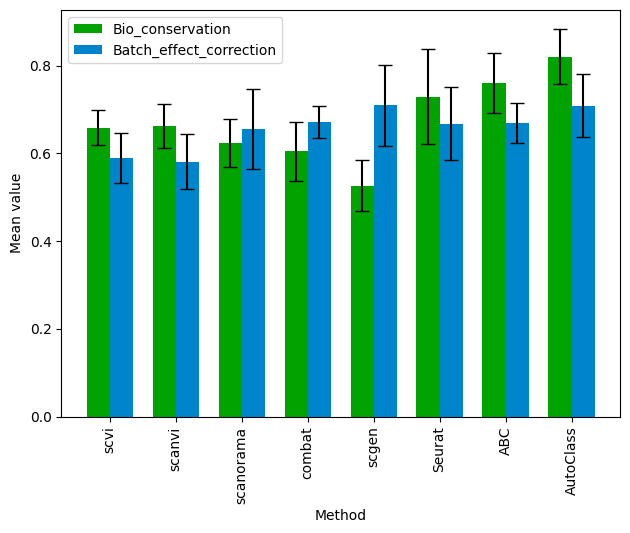

In [3]:
# Get the metrics to plot
metrics_to_plot = ['Bio_conservation', 'Batch_effect_correction']

# Get the unique methods
methods = combined_df['Method'].unique()

# Define the width of a bar and locations of labels
bar_width = 0.35
label_locs = np.arange(len(methods))


color_dict = {'Bio_conservation': '#00A300', 'Batch_effect_correction': '#0085CC'}
save_path = '/content/drive/MyDrive/Colab Notebooks/integrationDatasets/metricsPlots/'

for i, metric in enumerate(metrics_to_plot):
    # Group the data by 'Method' and calculate the mean and standard deviation for each group
    grouped_data = combined_df.groupby('Method',sort=False)[metric].agg(['mean', 'std'])

    # Plot the bar chart with error bars and colored bars
    bar_locs = label_locs + i*bar_width
    plt.bar(bar_locs, grouped_data['mean'], yerr=grouped_data['std'], capsize=5, color=color_dict[metric], width=bar_width, label=metric)

# Add legend and labels
plt.legend()
plt.xlabel('Method')
plt.ylabel('Mean value')
plt.tight_layout()
plt.xticks(label_locs + bar_width / 2, methods, rotation=90)  # set the location and labels of the x-ticks
if SAVE_FIG:
  plt.savefig(save_path + 'batchCorr_vs_bioCon-methodComaprison.png', format='png', dpi=300)
plt.show()


In [8]:
import plotly.offline as py


# Create a figure
fig = go.Figure()

# define plotting colors
colors = ['#ca8087', '#c0762b', '#b04c51', '#6e988c', '#658f47', '#b19e44', '#866b87', '#417185']


# Group the dataframe by 'Method' and calculate mean and std for each category
grouped = combined_df.groupby('Method').agg(['mean', 'std'])
method_index = list(grouped.index).index(method)
# For each method, add a trace to the figure with a point at the mean and error bars for the std
for method, group in grouped.iterrows():
    x_mean = group[('Batch_effect_correction', 'mean')]
    x_std = group[('Batch_effect_correction', 'std')]
    y_mean = group[('Bio_conservation', 'mean')]
    y_std = group[('Bio_conservation', 'std')]

    method_index = list(grouped.index).index(method)
    fig.add_trace(go.Scatter(
        x=[x_mean], y=[y_mean],
        error_x=dict(type='data', array=[x_std], visible=True),
        error_y=dict(type='data', array=[y_std], visible=True),
        mode='markers',
        name=method,
        # marker=dict(size=10)
        marker=dict(size=10, color=colors[method_index])

    ))

# Update layout to include labels and legend
fig.update_layout(
    xaxis_title='Batch Effect Correction Avg',
    yaxis_title='Biological Conservation Avg',
    autosize=False,
    width=750,
    height=800,
    legend=dict(
        x=1,
        y=1,
        traceorder="normal",
        font=dict(
            family="sans-serif",
            size=12,
            color="black"
        ),
        bgcolor="LightSteelBlue",
    )
)


# Show the plot
fig.show()
py.plot(fig, filename='my_figure.html', auto_open=True)



'my_figure.html'

In [7]:
# plot hyperparameter optimization

import os
import pandas as pd
import plotly.graph_objects as go


path = '/content/drive/MyDrive/Colab Notebooks/integrationDatasets/final_metrics/'
metrics_file1 = os.path.join(path, f'small_atac_gene_activity_hyperParamOpt.csv')
metrics_file2 = os.path.join(path, f'human_pancreas_norm_complexBatch_hyperParamOpt.csv')

# Read the CSV files into pandas DataFrames, using the first column as the index
atac_gene_df = pd.read_csv(metrics_file1, index_col=0)
pancreas_df = pd.read_csv(metrics_file2, index_col=0)


# Add new columns for the average metrics and drop unnecessary ones
atac_gene_df['Bio_conservation'] = atac_gene_df[bio_con_metrics[:-3]].mean(axis=1)
pancreas_df['Bio_conservation'] = pancreas_df[bio_con_metrics[:-1]].mean(axis=1)

atac_gene_df['Batch_effect_correction'] = atac_gene_df[batch_corr_metrics].mean(axis=1)
pancreas_df['Batch_effect_correction'] = pancreas_df[batch_corr_metrics].mean(axis=1)

atac_gene_df['Final_Score'] = atac_gene_df['Bio_conservation'] * 0.5 + atac_gene_df['Batch_effect_correction'] * 0.5
atac_gene_df.drop(['Bio_Conservation_avg', 'Batch_Correction_avg'], axis=1, inplace=True)

pancreas_df['Final_Score'] = pancreas_df['Bio_conservation'] * 0.5 + pancreas_df['Batch_effect_correction'] * 0.5
pancreas_df.drop(['Bio_Conservation_avg', 'Batch_Correction_avg'], axis=1, inplace=True)


# Select avg columns
atac_gene_df = atac_gene_df[['Final_Score', 'Bio_conservation', 'Batch_effect_correction']]
pancreas_df = pancreas_df[['Final_Score', 'Bio_conservation', 'Batch_effect_correction']]


# Merge the two DataFrames on the index
df = atac_gene_df.merge(pancreas_df, left_index=True, right_index=True, suffixes=("_geneAtac", "_pancreas"))
df['avg_final_score'] = (df['Final_Score_geneAtac'] + df['Final_Score_pancreas']) / 2
df['avg_Batch_Correction'] = (df['Batch_effect_correction_geneAtac'] + df['Batch_effect_correction_pancreas']) / 2
df['avg_Bio_Conservation'] = (df['Bio_conservation_geneAtac'] + df['Bio_conservation_pancreas']) / 2

df.drop(['Batch_effect_correction_geneAtac', 'Batch_effect_correction_pancreas',
         'Bio_conservation_geneAtac', 'Bio_conservation_pancreas'], axis=1, inplace=True)

df = df.reindex(columns=['Final_Score_geneAtac', 'Final_Score_pancreas', 
                         'avg_Batch_Correction', 'avg_Bio_Conservation', 
                         'avg_final_score'])


# sort by final score
df = df.sort_values(by='avg_final_score', ascending=False)

# save the dataframe
# orig_base_path = '/content/drive/MyDrive/Colab Notebooks/integrationDatasets/'
# metrics_path = os.path.join(orig_base_path, 'metrics/')
df.to_csv(path + 'hyperParamOpt_processedResults.csv')


# Display top ten combinations
df = df[:10]
df = df.round(5)


column_widths = [250] * (len(df.columns) + 1)  # Initialize column widths
column_widths[0] = 200  

fig = go.Figure(data=[go.Table(
    header=dict(values=[''] + list(df.columns),
                fill_color='lightblue',
                align='left'),
    cells=dict(values=[df.index] + [df[col] for col in df.columns],
               fill_color='white',
               align='left'))
])

fig.update_layout(width=1200, height=600)
fig.update_traces(columnwidth=column_widths)  # Set column widths

fig.show()

